![Traffic](traffic.png)

Traffic data fluctuates constantly or is affected by time. Predicting it can be challenging, but this task will help sharpen your time-series skills. With deep learning, you can use abstract patterns in data that can help boost predictability.

Your task is to build a system that can be applied to help you predict traffic volume or the number of vehicles passing at a specific point and time. Determining this can help reduce road congestion, support new designs for roads or intersections, improve safety, and more! Or, you can use to help plan your commute to avoid traffic!

The dataset provided contains the hourly traffic volume on an interstate highway in Minnesota, USA. It also includes weather features and holidays, which often impact traffic volume.

Time to predict some traffic!

### The data:

The dataset is collected and maintained by UCI Machine Learning Repository. The target variable is `traffic_volume`. The dataset contains the following and has already been normalized and saved into training and test sets:

`train_scaled.csv`, `test_scaled.csv`
| Column     | Type       | Description              |
|------------|------------|--------------------------|
|`temp`                   |Numeric            |Average temp in kelvin|
|`rain_1h`                |Numeric            |Amount in mm of rain that occurred in the hour|
|`snow_1h`                |Numeric            |Amount in mm of snow that occurred in the hour|
|`clouds_all`             |Numeric            |Percentage of cloud cover|
|`date_time`              |DateTime           |Hour of the data collected in local CST time|
|`holiday_` (11 columns)  |Categorical        |US National holidays plus regional holiday, Minnesota State Fair|
|`weather_main_` (11 columns)|Categorical     |Short textual description of the current weather|
|`weather_description_` (35 columns)|Categorical|Longer textual description of the current weather|
|`traffic_volume`         |Numeric            |Hourly I-94 ATR 301 reported westbound traffic volume|
|`hour_of_day`|Numeric|The hour of the day|
|`day_of_week`|Numeric|The day of the week (0=Monday, Sunday=6)|
|`day_of_month`|Numeric|The day of the month|
|`month`|Numeric|The number of the month|
|`traffic_volume`         |Numeric            |Hourly I-94 ATR 301 reported westbound traffic volume|

In [2]:

## 1. Imports and Setup
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error, r2_score
import math


In [3]:
## 2. Data Loading
train_scaled_df = pd.read_csv('Data/train_scaled.csv')
test_scaled_df = pd.read_csv('Data/test_scaled.csv')
train_scaled = train_scaled_df.to_numpy()
test_scaled = test_scaled_df.to_numpy()


In [4]:
## 3. Sequence Preparation
def create_sequences(data, seq_length, y_col_idx):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length, y_col_idx]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 12
Y_COL_IDX = -1
X_train, y_train = create_sequences(train_scaled, SEQ_LENGTH, Y_COL_IDX)
X_test, y_test = create_sequences(test_scaled, SEQ_LENGTH, Y_COL_IDX)


In [5]:
## 4. DataLoader Preparation
def get_dataloader(X, y, batch_size=64, shuffle=True):
    dataset = TensorDataset(
        torch.tensor(X.astype(np.float32)), torch.tensor(y.astype(np.float32))
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

dataloader_train = get_dataloader(X_train, y_train, shuffle=True)
dataloader_test = get_dataloader(X_test, y_test, shuffle=False)


In [7]:
## 5. Model Definition
class TrafficVolume(nn.Module):
    def __init__(self, input_size=66, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.relu = nn.LeakyReLU()
        self.fc1 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (h_0, _) = self.lstm(x)
        out = h_0[-1]
        return self.relu(self.fc1(out))

n_features = X_train.shape[2]
traffic_model = TrafficVolume(input_size=n_features)


In [8]:
## 6. Training Loop
def train_model(model, dataloader, criterion, optimizer, epochs=2):
    model.train()
    train_losses = []  # Initialize list to store training loss per epoch
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        average_loss = epoch_loss / len(dataloader)
        train_losses.append(average_loss)
        print(f"Epoch: {epoch+1}, train loss: {average_loss:.5f}")
    return train_losses

criterion = nn.MSELoss()
optimizer = optim.Adam(traffic_model.parameters(), lr=0.0001)
train_losses = train_model(traffic_model, dataloader_train, criterion, optimizer, epochs=2)


Epoch: 1, train loss: 0.07662
Epoch: 2, train loss: 0.02749


In [10]:
## 7. Evaluation
traffic_model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for seqs, labels in dataloader_test:
        outputs = traffic_model(seqs).squeeze()
        all_predictions.append(outputs)
        all_labels.append(labels)

all_predictions = torch.cat(all_predictions).cpu().numpy()
all_labels = torch.cat(all_labels).cpu().numpy()

test_mse = F.mse_loss(torch.tensor(all_predictions), torch.tensor(all_labels))
print(f'Test MSE: {test_mse.item():.5f}')

# Additional metrics
mae = mean_absolute_error(all_labels, all_predictions)
rmse = math.sqrt(test_mse.item())
r2 = r2_score(all_labels, all_predictions)
print(f"Test MAE: {mae:.5f}")
print(f"Test RMSE: {rmse:.5f}")
print(f"Test R2: {r2:.5f}")


Test MSE: 0.01973
Test MAE: 0.11025
Test RMSE: 0.14048
Test R2: 0.73151


## 8. Model Accuracy Discussion
The accuracy of the model's decisions depends on the values of the evaluation metrics:
- **MAE** (Mean Absolute Error) and **RMSE** (Root Mean Squared Error) indicate how close the predictions are to the actual traffic volume values. Lower values mean better accuracy.
- **R²** (R-squared) shows how well the model explains the variance in the data. Values closer to 1 indicate more accurate predictions.

You can compare these metrics to the scale of your target variable to judge if the model is making sufficiently accurate decisions for your application. For further improvement, consider tuning hyperparameters, increasing training epochs, or using more advanced architectures.


## 9. Visualizing Model Performance
Visualizations can help you better understand your model's predictions and errors. Common plots include:
- **Predicted vs Actual**: Shows how close your predictions are to the true values.
- **Residuals**: Highlights where your model makes larger errors.
- **Loss Curve**: Tracks training loss over epochs (if you save loss values during training).


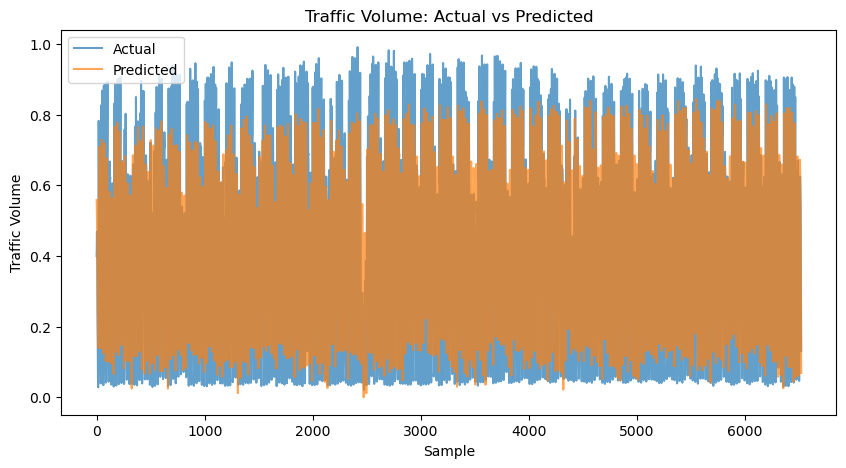

In [11]:
### Example: Predicted vs Actual Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(all_labels, label='Actual', alpha=0.7)
plt.plot(all_predictions, label='Predicted', alpha=0.7)
plt.title('Traffic Volume: Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()


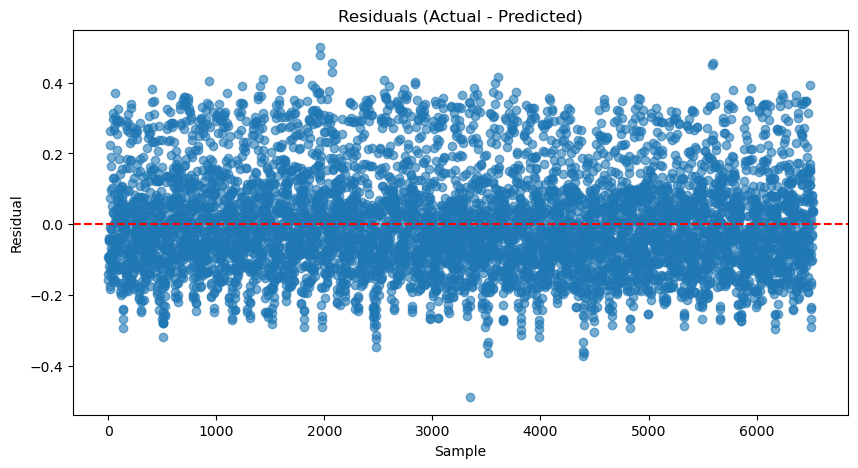

In [14]:
### Example: Residual Plot
# Residuals: difference between actual and predicted
residuals = all_labels - all_predictions
plt.figure(figsize=(10, 5))
# Scatter a plot of residuals for each sample
plt.scatter(range(len(residuals)), residuals, alpha=0.6)
# Add a horizontal line at zero for reference
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals (Actual - Predicted)')
plt.xlabel('Sample')
plt.ylabel('Residual')
plt.show()
# The residual plot helps you see where your model makes larger errors. Points far from zero indicate less accurate predictions. Ideally, residuals should be randomly scattered around zero.
